<a href="https://colab.research.google.com/github/utkarshp1161/SIFTrVAE/blob/main/VAE_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SIFT rVAE analysis on Graphene STEM data

## get data

In [ ]:
# reference notebook: https://github.com/saimani5/VAE-tutorials/blob/main/rvae_graphene.ipynb

In [1]:
# # Download the dataset, Will explain what each file corresponds to later
# !gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
# !gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
# !gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

## some installations and imports

In [2]:
# Installing Kornia and pyroved
# !pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main

In [3]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pyroved as pv
import kornia as K
from torchvision import datasets

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
tt = torch.tensor

# data import

In [4]:
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

Text(0.5, 1.0, 'Atomic coordinates')

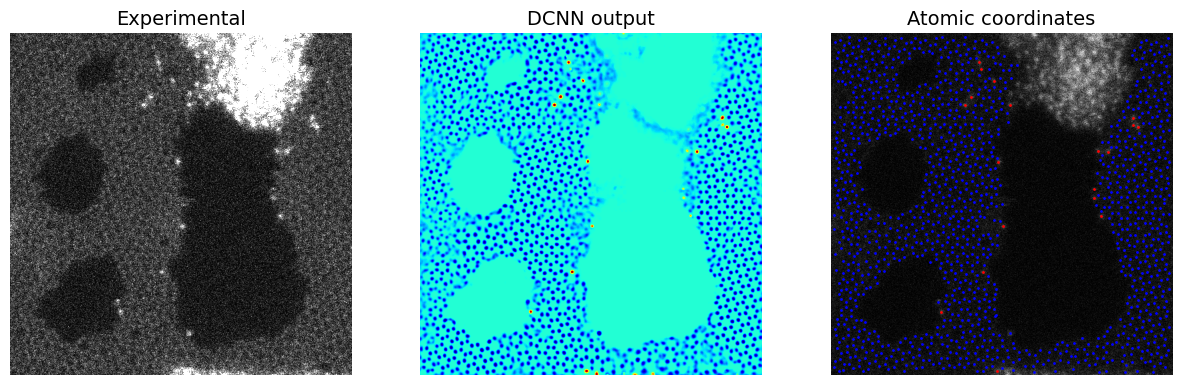

In [18]:
#Visulaizing one frame of the data, we have 50 frames (0-49)

i = 49 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]#     silicon atom
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]# carbon atom
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

## Regular rVAE analysis - we wont train but load weights and see output just to build up towards SIFTrVAE

In [53]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below
window_size = 40   # Window_size
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

In [54]:
#Setting the train loader
imstack = tt(s.imgstack[:,None,:,:, 0])# 
train_loader_graphene = pv.utils.init_dataloader(imstack, batch_size=50)
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

In [60]:
imstack.shape, frames_all.shape,com_all.shape, decoded_imgs.shape, lattice_coord.keys() #73995 all atoms 

(torch.Size([73995, 1, 40, 40]),
 (73995,),
 (73995, 2),
 (50, 512, 512, 3),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

In [64]:
lattice_coord[0].shape, lattice_coord[3].shape

((2042, 3), (2056, 3))

In [68]:
frames_all[:5000]

array([0, 0, 0, ..., 2, 2, 2])

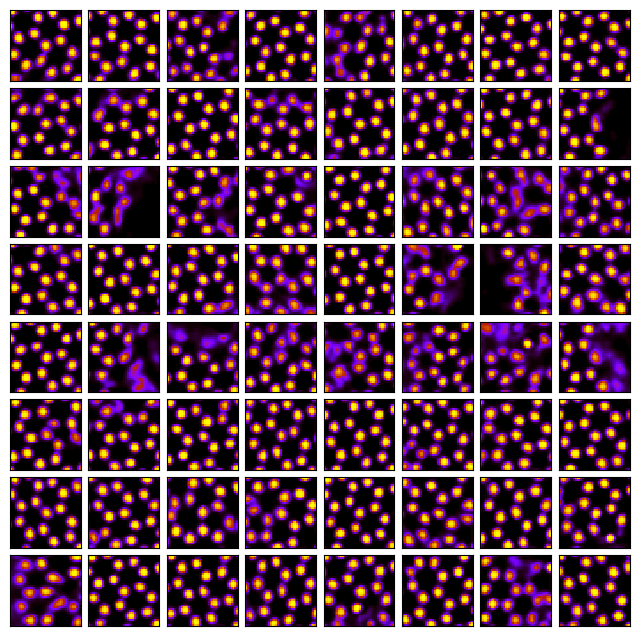

In [10]:
# Visulaizing the training dataset
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

# plt.savefig('example_imgs.png', dpi = 300)

In [147]:
# Initializing a new network
in_dim = (40, 40)
rvae_graphene = pv.models.iVAE(in_dim, latent_dim=2,
                               hidden_dim_e = [512, 512],
                               hidden_dim_d = [512, 512],
                               invariances=['r', 't'], seed=0)

# Download the weigths file 
# !gdown 1bCuzOM5TJL_zQQS-B_ka1vyCX4FYNDV5

# Loading the saved weights into the newly initialized network
rvae_graphene.load_weights('rvae_graphene.pt')

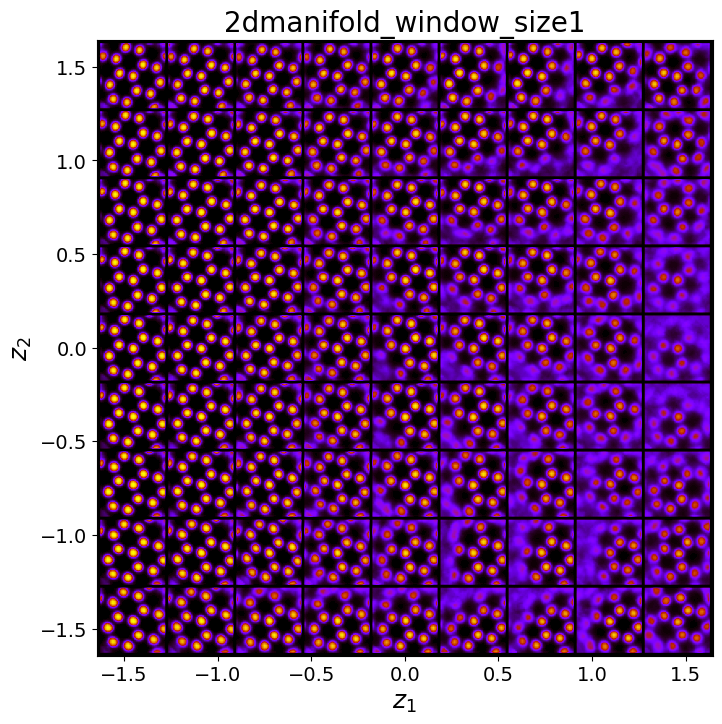

In [74]:
# Visualizing decoded latent space
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

rvae_graphene.manifold2d(d = 9)   # d corresponds to the number of points sampled in each latent dimension

In [149]:
z_mean, z_sd = rvae_graphene.encode(imstack)   # Encoding the full input dataset
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

# z_mean1: mean of the latent space representation of the input dataset, 
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column (z1): corresponds to angle and 
# 1st columsn (z2): Corresponds to the translations
# (z3) then the regular latent dimensions 

In [82]:
#Visualizing the latent space encodings on the raw STEM image

frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()

## SIFTrvae

In [128]:
# plotting utility
from pyroved.utils import generate_latent_grid, plot_img_grid
from typing import Optional, Tuple, Union, List
from typing import Union, List, Tuple
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

#*****************************************************manifold2d
def plot_img_grid_custom(imgdata: torch.Tensor, d: int, ws: int,
                  **kwargs: Union[str, int, List[float]]) -> None:
    """
    Plots a *d*-by-*d* square grid of 2D images
    """
    if imgdata.ndim < 3:
        raise AssertionError("Images must be passed as a 3D or 4D tensor")
    imgdata = imgdata[:, None] if imgdata.ndim == 3 else imgdata
    grid = make_grid(imgdata, nrow=d,
                     padding=kwargs.get("padding", 2),
                     pad_value=kwargs.get("pad_value", 0)).cpu()
    extent = kwargs.get("extent")
    # Put on cpu in case all tensors are created on gpu by default
    extent_ = [e.cpu() for e in extent]
    plt.figure(figsize=(8, 8))
    plt.imshow(grid[0].squeeze(), cmap=kwargs.get("cmap", "gnuplot"),
               origin=kwargs.get("origin", "upper"),
               extent=extent_)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    plt.title(f"2dmanifold_window_size{ws}", fontsize=20)
    plt.savefig(f"2dmanifold_window_size{ws}")
    plt.show()


def get_custom_manifold2d(local_vae, d: int, ws=1):
    """
    Plots a learned latent manifold in the data space

    Args:
        d: Grid size
        plot: Plots the generated manifold (Default: True)
        y: Conditional "property" vector (e.g. one-hot encoded class vector)
        kwargs: Keyword arguments include custom min/max values
                for grid boundaries passed as 'z_coord'
                (e.g. z_coord = [-3, 3, -3, 3]), 'angle' and
                'shift' to condition a generative model on, and plot parameters
                ('padding', 'pad_value', 'cmap', 'origin', 'ylim')
    """
    z, (grid_x, grid_y) = generate_latent_grid(d)
    z = [z]

    loc = local_vae.decode(*z, )

    plot_img_grid_custom(
                loc, d,ws = ws,
                extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

     
    
    return loc


#**************************************************************************latent representation with KDE

def plot_latent_rep_with_kde(z_mean, z_sd, ws):

   
    plt.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='jet', alpha=0.5)
    sns.kdeplot(x=z_mean[:, -1], y=z_mean[:, -2], fill=True, thresh=0.01, levels=100, cmap="Greens", shade=True, alpha=0.5)

    plt.xlabel("z1", fontsize=14)
    plt.ylabel("z2", fontsize=14)
    plt.title(f"latent distribution_window_size{ws}", fontsize=20)
    plt.savefig(f"latent_distribution_window_size{ws}.png")


#****************************************plot latent images

def visualize_latent_images(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws):
    """
    Visualizes the latent space encodings on the raw STEM image for a given frame.

    Parameters:
    - frame: The frame number to visualize.
    - com_all: Array containing coordinates for all frames.
    - frames_all: Array indicating the frame number for each coordinate in com_all.
    - lattice_coord: List of arrays containing lattice coordinates for each frame.
    - z1: Array of latent variables (image) related to the encoded angle.
    - z3: Array of latent variables (image) with dimensions for different features.
    - STEM_real: Array containing the raw STEM images.

    Returns:
    - None: Displays a matplotlib figure with the visualization.
    """
    com_i = com_all[frames_all == frame]  # get coordinates for this frame
    com_i_Si = lattice_coord[frame]  # get Si coordinates for plotting
    com_i_Si = com_i_Si[com_i_Si[:, -1] == 1.]
    z1_i = z1[frames_all == frame]  # get latent variables (image) for this frame
    z3_i = z3[frames_all == frame]  # get latent variables (image) for this frame

    col_min0 = z1.min()
    col_max0 = z1.max()
    col_min1 = z3[:, 0].min()
    col_max1 = z3[:, 0].max()
    col_min2 = z3[:, 1].min()
    col_max2 = z3[:, 1].max()

    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
                  cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[0].set_title("Encoded angle", fontsize=18)
    ax[1].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
                  cmap="jet", vmin=col_min1, vmax=col_max1)
    ax[1].set_title("Latent variable 1", fontsize=18)
    ax[2].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
                  cmap="jet", vmin=col_min2, vmax=col_max2)
    ax[2].set_title("Latent variable 2", fontsize=18)
    for _ax in fig.axes:
        _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
        _ax.axis(False)
    fig.suptitle(f"latent_images_windowsize{ws}_for frame{frame}", fontsize=20)
    plt.savefig(f"{frame}_latent_image_window_size{ws}.png")
    plt.show()
    

# Example of calling the function:
# visualize_latent_encodings(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real)


In [106]:
# def atom_evolution(M_largest_ws, lattice_coord_largest_ws, vae):
#     """
    
#     returns: N*M*L array: M is number of atoms
    
#     """
#     zmean, _ = vae

In [240]:
# what window sizes are you interested in?
ws = np.arange(10, 80, 5)
from tqdm import tqdm
ws

array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])

In [241]:
window_size = ws[-1]   # max windows size
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

In [242]:
#Setting the train loader
imstack = tt(s.imgstack[:,None,:,:, 0])# 
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

In [243]:
# make new lattice coordinate as changing window size might lead to loss of atoms so lets use the lasgest windows size and get atoms for that and that will be consisiten always
lattice_coord_largest = {}
for frame in np.unique(frames_all):
    temp = com_all[frames_all == frame]
    ## Add another column to lattice_coord_largest[frame] to represent atom type all_zeros
    zeros_column = np.zeros((temp.shape[0], 1))

    # Append the column of zeros to the original array to make its shape (1425, 3)
    lattice_coord_largest[frame] = np.hstack((temp, zeros_column))
    

In [244]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below
s_list = []
for i, window_size in tqdm(enumerate(ws)):
    s_list.append(aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord_largest, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0))

14it [00:16,  1.21s/it]


In [245]:

imstack_list = []
frames_all_list = []
com_all_list = []
for i, s in tqdm(enumerate(s_list)):
    imstack_list.append(s.imgstack[:,None,:,:, 0].reshape(-1,ws[i],ws[i]))
    frames_all_list.append(s.imgstack_frames)
    com_all_list.append(s.imgstack_com)


    

14it [00:00, 22602.10it/s]


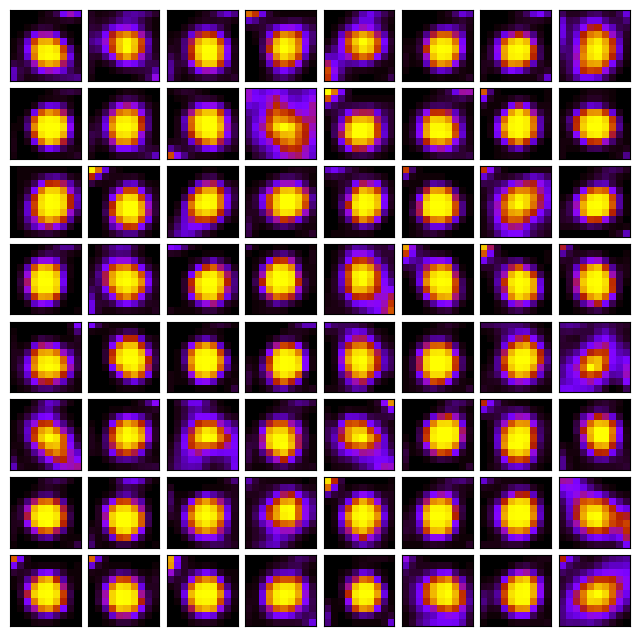

In [246]:
# Visulaizing the training dataset
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack_list[0]))
    ax.imshow(imstack_list[0][i], cmap='gnuplot', interpolation='nearest')

In [247]:
imstack_list[0].shape

(61197, 10, 10)

In [248]:
import cv2
import numpy as np

def resize_image_stack(imstack_list, size=(40, 40)):
    """
    Resize each image in each image stack within the given list of image stacks.
    
    Parameters:
    - imstack_list: List of image stacks, where each image stack is a list/array of images.
    - size: Desired size (width, height) to which each image will be resized.
    
    Returns:
    - List of resized image stacks.
    """
    resized_imstack_list = []
    for imstack in imstack_list:
        # Resize each image in the current imstack
        resized_imstack = np.array([cv2.resize(img, size, interpolation=cv2.INTER_LINEAR) for img in imstack])
        # Append the resized imstack to the new list
        resized_imstack_list.append(resized_imstack)
    return resized_imstack_list

# Assuming imstack_list, imstack_train_list, and imstack_test_list are predefined lists of image stacks

# Resize training and testing image stacks
resized_imstack_list = resize_image_stack(imstack_list)

# At this point, resized_imstack_list, resized_imstack_train_list, and resized_imstack_test_list 
# contain the resized versions of the respective image stacks.


In [249]:
final_train_list = []
train_loader_list  = []
for data in resized_imstack_list:
    final_train_list.append(tt(data))
    train_loader_list.append(pv.utils.init_dataloader(final_train_list[-1], batch_size=512))




In [251]:
window_size_consistent = 40
# Ititialize model
in_dim = (window_size_consistent, window_size_consistent)
rvae_super = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                               hidden_dim_e = [512, 512],   # corresponds to the number of neurons in the hidden layers of the encoder
                               hidden_dim_d = [512, 512],   # corresponds to the number of neurons in the hidden layers of the decoder
                               invariances=['r', 't'], seed=0)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_super)


In [253]:
array_evoluton = []
for i,j in tqdm(enumerate(ws)):
    print("window_size", j)
    for e in range(4):
        trainer.step(train_loader_list[i], scale_factor=3)
        trainer.print_statistics()
        
    
    z_mean, z_sd = rvae_super.encode(final_train_list[i])
    array_evoluton.append(z_mean)
    # plot latent manifold:
    get_custom_manifold2d(rvae_super,d = 9, ws = j);   # d corresponds to the number of points sampled in each latent dimension
    # plot latent rep
    plot_latent_rep_with_kde(z_mean, z_sd, ws = j)
    # plot latent images
    z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]
    visualize_latent_images(0, com_all_list[i], frames_all_list[i], lattice_coord, z1, z3, STEM_real, ws =j)#lattice_coord_largest_ws
    visualize_latent_images(25, com_all_list[i], frames_all_list[i], lattice_coord, z1, z3, STEM_real, ws =j)
    visualize_latent_images(49, com_all_list[i], frames_all_list[i], lattice_coord, z1, z3, STEM_real, ws =j)
    
    
    
    

0it [00:00, ?it/s]

window_size 10


0it [00:03, ?it/s]


KeyboardInterrupt: 

## make video

In [148]:
import cv2
import os
def create_video_recursive(base_folder, fps=30, frame_size=(640, 480), extension=".png", name = "video"):
    """
    Recursively creates video files from sequences of images in subfolders.

    Args:
        base_folder (str): The path to the base folder from where to start the recursive process.
        fps (int, optional): The frame rate of the output video. Defaults to 30.
        frame_size (tuple, optional): The size of the output video frames as a tuple of (width, height) in pixels. Defaults to (640, 480).
        extension (str, optional): The file extension of the image files to include in the video. Defaults to ".png".

    Returns:
        None
    """
    # Walk through the base folder recursively
    for folder_path, _, _ in os.walk(base_folder):
        # Get a list of all the image files in the current folder
        file_list = [f for f in os.listdir(folder_path) if f.endswith(extension)]
        
        # If there are no images in the current folder, skip it
        if not file_list:
            continue

        # Create a VideoWriter object to write the output video
        output_file = os.path.join(folder_path, f"{os.path.basename(folder_path)}{name}.avi")
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

        # Loop over the image files and add them to the output video
        for file_name in sorted(file_list):  # Sorting to ensure images are processed in order
            # Read the image file
            img = cv2.imread(os.path.join(folder_path, file_name))

            # Resize the image to the output size
            img = cv2.resize(img, frame_size)

            # Write the image to the output video
            out.write(img)

        # Release the VideoWriter object
        out.release()

In [149]:
create_video_recursive("/nfs/home/upratius/scratch/projects/VAE_superresolutioon/mani_repo/relevant_for_me/manifold/", name = "manifold")